# Red wine classification 

The Red wine dataset is related to variants of Portuguese "Vinho Verde" wine, collected by Paulo Cortez, see [Cortez et al., 2009.](http://www3.dsi.uminho.pt/pcortez/wine5.pdf).
The dataset is composed of 1599 samples of red wine, each sample is described by 11 physicochemical properties and a quality score ranging from 1 (bad) to 10 (excellent). 
The input variables are: the fixed acidity, volatile acidity, citric acid, residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide, density, pH, sulphates and the alcohol. 
More information can be found [here](https://s3.amazonaws.com/udacity-hosted-downloads/ud651/wineQualityInfo.txt).

Considering the 11 physicochemical properties as predictor variables, the goal is the predict the wine quality as a target variable.
As the values are all numerical, this dataset analysis can be considered as a regression or a classification work. 
In this study, we investigate both regression and classification models.
Moreover, we consider 2 different metrics: the Root mean squared error (RMSE) and the accuracy score.
The goal is to present an overview of the Machine Learning algorithms performance for predicting the quality wine on this dataset.

A naive baseline is provided with the k-Nearest Neighbors Regressor algorithm.
It helps yields a range of the performance's results for Machine Learning models predicting the target variable from the predictor variables.
Then, we adopt a classification strategy, considering 3 classes of quality, see **repo white-wine** on White wine for a binary classification.
We focus on classifier such as Logistic Regression, Decision Tree, Random Forest, K-Nearest Neighbors and Support Vector Machine.
Furthermore, to optimize the models, we proceed to a [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) on grid parameters with a [Cross-validation](https://github.com/christelle-git/Cross-validation/).
The hyperparameters are easily tuned for an overall overview of models' performance.

Outline:
* 1) Data insights
* 2) Data processing
* 3) Naive baseline with k-NN Regressor
* 4) Classification models
* 5) Conclusion

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ShuffleSplit
from sklearn import preprocessing
from sklearn import neighbors, metrics, dummy
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import xgboost

# 1) Data insights
## 1.1) Loading

In [2]:
data = pd.read_csv('winequality-red.csv', sep=";")
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


## 1.2) Distribution of quality

Text(0.5, 1.0, 'Red wines')

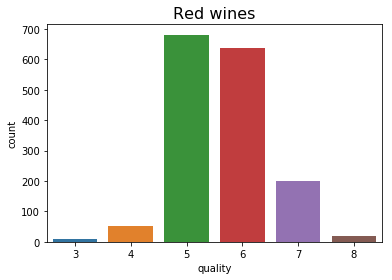

In [3]:
sns.countplot(data=data, x="quality")
plt.title("Red wines", fontsize=16)

There are only 6 unique values for the quality score in the dataset, they range from 3 to 8.
The distribution of quality is heavily centred around 5 and 6. 
We overall identify 3 classes separating data: [3,4], [5,6] and [7,8].

The classes are not balanced, there are much more medium wines than excellent or poor ones. 
Consequently, the classification is difficult and tight.
Most algorithms might tend to focus their predictions around 5 and 6, making the others quality scores more difficult to predict.

## 1.3) Correlations between features 

The heat map below provides the correlation of each features with respect to others.

* 0 $\Leftrightarrow$ no relationship between variables.
* 1 $\Leftrightarrow$ positive relationship between variables.
* -1 $\Leftrightarrow$ negative relationship between variables.

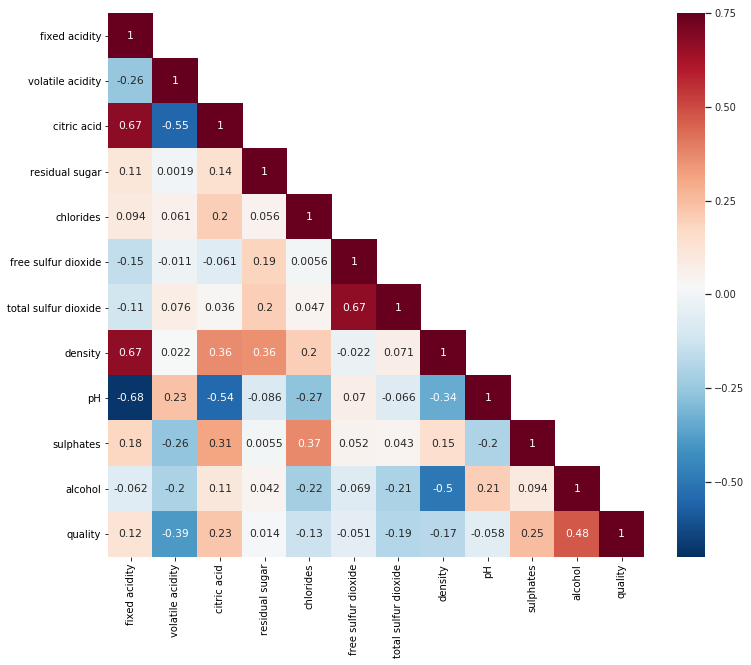

In [4]:
corrmat = data.corr()
mask = np.zeros_like(data.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask, k=1)] = True

fig, ax = plt.subplots(figsize=(12,10))
sns.set(font_scale=0.9)
sns.heatmap(corrmat, vmax=.75, vmin=-0.7, 
            annot=True, 
            cmap='RdBu_r', #winter/RdBu_r
            mask=mask) 
plt.show()

The inferences from the heat map are as follows:
* density and acidity are the most positively correlated variables.<br>
  (total sulfur dioxide and free sulfur dioxide as well) 
* acidity has strong negative correlation with pH.
* density has negative correlation with alcohol.
* quality has the most positive correlation with alcohol. 
* quality has no relationship with residual_sugar and pH.

=> the most positively correlated variable with quality is alcohol. 

## 1.4) Features distribution

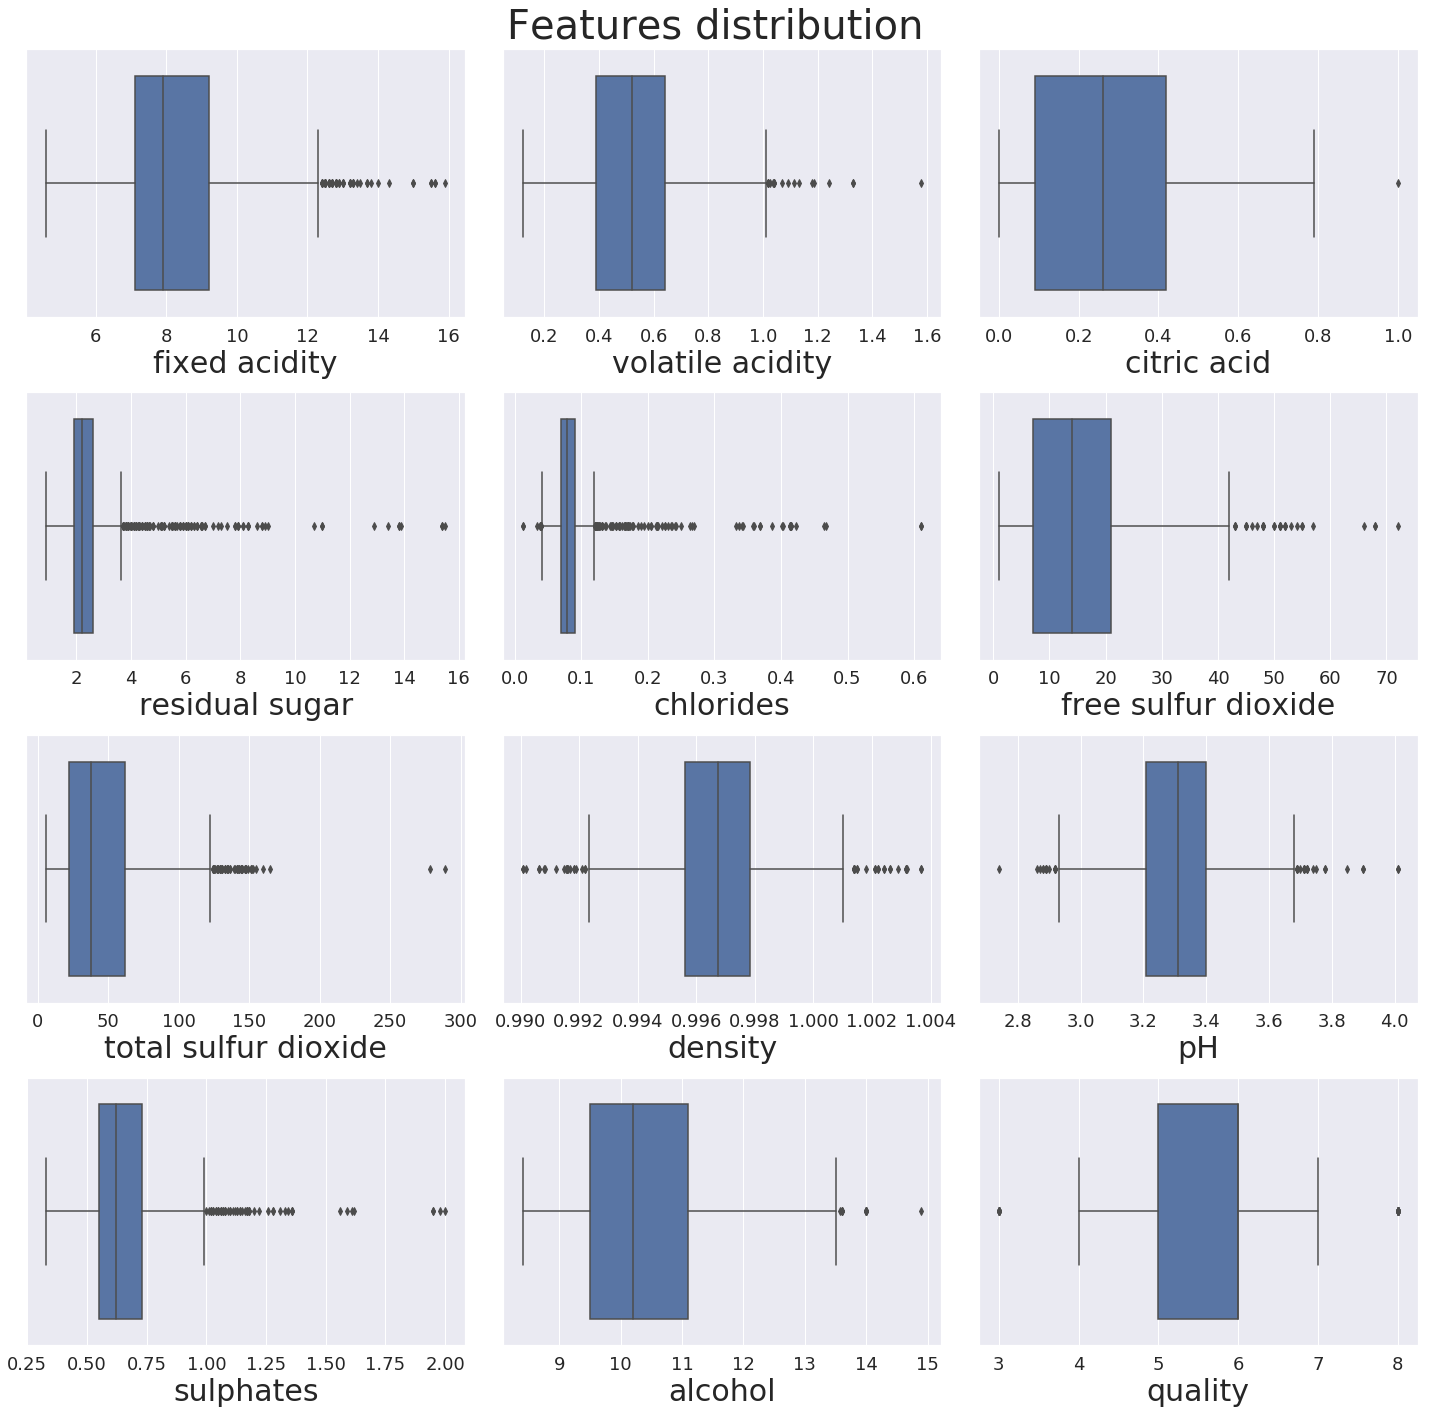

In [67]:
plt.figure(figsize=(20,20))
for i in range(0,len(data.columns)-1):
    plt.subplot(4,3,i+1)
    parameterName = data.columns[i]
    sns.boxplot(data[parameterName]);
    plt.xticks(fontsize=18)
    plt.xlabel(parameterName, fontsize=30)
plt.suptitle('Features distribution', size=40)
plt.tight_layout()
plt.subplots_adjust(top=0.95)

plt.show()

We observe on boxplots many outliers for quite features.
This can be induced by a high variance in values or poor number of low and high samples.

The quality is highly condensed in the mean value.

# 2) Data processing
## 2.1) Categorical feature

In this study we turn the problem into a multi-class classification problem.
We separate the quality values into 3 classes: <br>
• low  [3,4]<br>
• medium [5,6]<br>
• high  [7,8]<br>

In [27]:
data['quality_label'] = \
    data.quality.apply(lambda q: 0 if q <= 4 
                       else 1 if q <= 6 
                       else 2)
# low :    0    [3,4]
# medium : 1    [5,6]
# high :   2    [7,8]
data["quality_label"].value_counts(ascending=True)

0      63
2     217
1    1319
Name: quality_label, dtype: int64

Text(0.5, 1.0, 'Red wines quality')

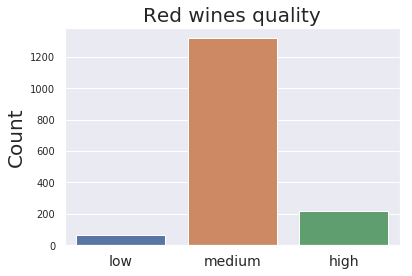

In [34]:
sns.countplot(data=data, x="quality_label")
plt.xticks([0,1,2],['low', 'medium', 'high'], fontsize=14)
plt.xlabel('')
plt.ylabel('Count', fontsize=20)
plt.title("Red wines quality", fontsize=20)

As expected, the data are not well balanced, so the classification might be rough estimated.

## 2.2) Splitting & standardising

In [8]:
X = data.drop(['quality','quality_label'], axis =1)
y = data['quality_label']

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, 
                     test_size=0.3,
                     #stratify=y,
                     random_state=10)

# STANDARDISING
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

# 3) Naive baseline with k-NN Regressor

In this section, we first provide a baseline predictor.
The goal is to create a naive baseline that yields a range of the performance's results for Machine Learning models to predict the target variable quality from the others features.

Since the quality is numerical, a regression algorithm can be applied.
Thus, we consider the regression model of k-Nearest Neighbors Regressor and the associated scoring metrics is the Root Mean Squared Error (RMSE).
Indeed, since the quality score is unbalanced, the accuracy score metrics might loses relevance. 
Overcoming this issue, the RMSE provides the distance to the correct label, which the accuracy metrics lacks to provide.
In order to compare with the classification model's accuracy, an approximated accuracy is evaluated by the usual formula for basis classifier.

Then the basis algorithm is optimized with a Grid-Search strategy on Cross-validation with 10-folds.

## 3.1) Default k-Nearest Neighbors Regressor

As a naive baseline, we apply the k-Nearest Neighbors Regressor and evaluate the performance with the Root Mean Squared Error (RMSE) metrics, defined by

\begin{equation*}
RMSE = \sqrt{\dfrac{1}{n}\sum_{i=1}^n(y_i-\hat{y}_i)^2},
\end{equation*}
where $n$ is the number of samples, $y$ is the true values vector and $\hat{y}$ is the predicted values vector.

However, we muste take into account that the RMSE is not robust to outliers.
As the dataset is full of outliers, the result might not be very reliable.
As a comparative measure, an approximated accuracy score is provided computed by the  discrete formula of the accuracy score; see 4).

In [9]:
# Default n_neighbors = 5 
knn = KNeighborsRegressor()
knn.fit(X_train_std, y_train)
y_pred = knn.predict(X_test_std)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error : %.4f" % rmse)

my_acc = (1./data.shape[0])*(sum(y_test == y_pred))
print("My corresponding accuracy score: ~%.0f%%" % ((1.- my_acc)*100))

Root Mean Squared Error : 0.3727
My corresponding accuracy score: ~84%


## 3.2) Grid search on k-NN Regressor

We improve the performance by optimizing the models using a Grid-Search on hyper-parameters and a Cross-validation with 10-folds.

In [10]:
list_neigh = [3, 5, 7, 9, 11, 13, 15, 17, 20, 23, 25, 27]
param_grid = [{'n_neighbors':list_neigh, 
               'weights': ['uniform', 'distance']
              }]
nbfolds = 10
skf = StratifiedKFold(n_splits = nbfolds, 
                      shuffle = True, 
                      random_state = 20)
clf_gs = GridSearchCV(KNeighborsRegressor(), 
                   param_grid,
                   scoring="r2",
                   cv = skf)
clf_gs.fit(X_train_std, y_train)
print("Best hyperparameter on the training set: \n",clf_gs.best_params_)
y_pred_gs = clf_gs.predict(X_test_std)
rmse_gs = np.sqrt(mean_squared_error(y_test, y_pred_gs))
print("\nRoot Mean Squared Error (%d-folds): %.4f" % 
      (nbfolds, rmse_gs))
my_acc_gs = (1./data.shape[0])*(sum(y_test == y_pred_gs))
print("My corresponding accuracy score: ~%.0f%%" % ((1.- my_acc_gs)*100))

#print("\nBetter performance with 25 neighbors on 10-folds (on training)")
imp = 100*(rmse-rmse_gs)/rmse
print("\nGrid-Search => %.f%% of improvement" % imp)

Best hyperparameter on the training set: 
 {'n_neighbors': 20, 'weights': 'distance'}

Root Mean Squared Error (10-folds): 0.3287
My corresponding accuracy score: ~89%

Grid-Search => 12% of improvement


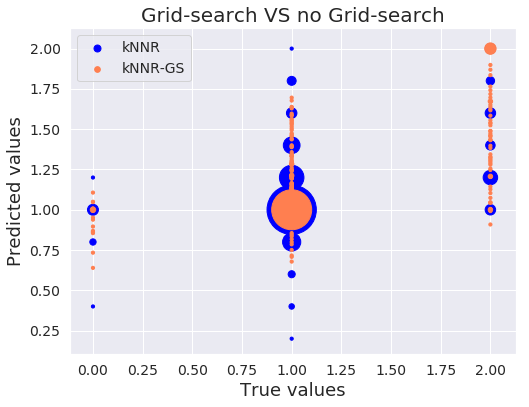

In [11]:
sizes = {}
sizes_gs = {}
amp = 10
for (yt, yp) in zip(list(y_test), list(y_pred)):
    if (yt, yp) in sizes:
        sizes[(yt, yp)] += amp
    else:
        sizes[(yt, yp)] = amp  
for (yt, yp) in zip(list(y_test), list(y_pred_gs)):
    if (yt, yp) in sizes_gs:
        sizes_gs[(yt, yp)] += amp
    else:
        sizes_gs[(yt, yp)] = amp     
plt.figure(figsize=(8,6))        
keys = sizes.keys()
plt.scatter([k[0] for k in keys], [k[1] for k in keys], 
            s = [sizes[k] for k in keys], 
            label="kNNR", color='blue')
keys = sizes_gs.keys()
plt.scatter([k[0] for k in keys], [k[1] for k in keys], 
            s = [sizes_gs[k] for k in keys], 
            label="kNNR-GS",color='coral')   
plt.xlabel("True values", fontsize=18)
plt.ylabel("Predicted values", fontsize=18)
plt.title("Grid-search VS no Grid-search", fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(loc="upper left",markerscale=0.2, fontsize=14)
plt.show()

The predicted values are condensed on the mean value 1 (medium quality), which is as expected related to the condensed values of the dataset in the mean.
The k-NN Regressor without Grid-search makes more wrong preditions.


# 4) Classification models

We apply different Machine Learning models as classifiers:
1. Logistic Regression
2. Decision Tree
3. Random Forest
4. K-Nearest Neighbors
5. Support Vector Machine

The metrics here is different from the Root Mean Squared Error used previously with the k-NN Regressor.
We consider the accuracy score defined by
\begin{equation*}
\mbox{accuracy}(y,\hat{y}) = \dfrac{1}{n}\sum_{i=1}^n\mathbb{1}_{\{y_i=\hat{y}_i\}}, 
%\mbox{where $n$ is the number of samples.} 
\end{equation*}
where $n$ is the number of samples and $\mathbb{1}$ is the indicator function.

The results are optimized by a Grid-search with Cross-validation.
The model's performance is evaluated by the accuracy metrics and the confusion matrix. 
The features importance barplot is also provided at the end in order to identify the most important variable in the quality classifying for Decision Tree and Random Forest models.

## 4.1) Default classifiers

In [12]:
models = []
models.append(('Logistic Regression    ', LogisticRegression()))
models.append(('Decision Tree          ', DecisionTreeClassifier()))
models.append(('Random Forest          ', RandomForestClassifier()))
models.append(('K-Nearest Neighbors    ', KNeighborsClassifier()))  
models.append(('Support Vector Machine ', SVC()))

conf_mat ={}
print("---- Model accuracy scores ----\n")
for name, model in models:
    model.fit(X_train_std, y_train)
    y_pred = model.predict(X_test_std)
    acc_score = accuracy_score(y_test, y_pred)
    print(name, ": %.2f%%" %  (acc_score*100))  
    conf_mat[name] = confusion_matrix(y_test, y_pred)

---- Model accuracy scores ----

Logistic Regression     : 83.75%
Decision Tree           : 80.42%
Random Forest           : 85.42%
K-Nearest Neighbors     : 82.92%
Support Vector Machine  : 83.54%


The results are quite similar to the k-Nearest Neighbors Regressor.
The accuracies are all in the same range of 80-90%.<br>
Throughout what follows we apply a Grid-search strategy in order to improve these results.

## 4.2) Grid-search

In order to improve the previous results, we perform a Grid-search on hyper-parameters by a 10-fold cross-validation.
It aims at optimizing the models by fitting the best hyper-parameters configuration.
Indeed, a better hyper-parameter tuning can fight over-fitting and could potientially increase accuracy.
 
The model performance metrics is the accuracy score as above.
Moreover, we also present the confusion matrices.

In [13]:
def grid_search(name_clf, clf):
    
    # Cross-validation k-folds
    nbsplit = 10
    #cv = ShuffleSplit(n_splits=nbsplit, test_size=0.3, random_state=3)
    cv = StratifiedKFold(n_splits=nbsplit, random_state=3, shuffle=True)
    #cv = nbsplit
    
    # GRID SEARCH PARAMETERS
    if name_clf == 'Logistic Regression    ':
        C_range = np.logspace(-4, 2, 6)
        params = {"penalty": ['l1', 'l2'], 
                  'C': C_range}
    
    elif name_clf == 'Decision Tree          ':
        params = {"criterion": ["gini", "entropy"], 
                  "max_depth": list(range(2,30,1)), 
                  "min_samples_leaf": list(range(1,20,1))}
    
    elif name_clf == 'Random Forest          ':
        params = {"bootstrap":[True, False], 
                  #"n_estimators": np.arange(10, 40, 10),
                  "max_depth": list(range(2,10,1)), 
                  "min_samples_leaf": list(range(1,20,1))}
        
    elif name_clf == 'K-Nearest Neighbors    ':
        k_range = list(range(1, 31))
        params = {'n_neighbors': k_range,
                  'weights': ['uniform','distance']}

    elif name_clf == 'Support Vector Machine ':        
        C_range = np.logspace(-1, 1, 3)       
        gamma_range = np.logspace(-1, 2, 4)
        params = {'C': C_range,
                  'kernel': ['rbf', 'linear', 'sigmoid'],
                  'gamma': gamma_range}
    
    gs_cv = GridSearchCV(clf, 
                        params, 
                        scoring='accuracy',
                        cv=cv,
                        n_jobs=-1)
    gs_cv.fit(X_train_std, y_train)
           
    best_params = gs_cv.best_estimator_
    #print("Best Parameters for ", name_clf, ": ", best_params)
    #print("Best Score: %.2f%%" % ((gs_cv.best_score_)*100))        
    return best_params
       
acc_score_gs = {}
conf_mat_gs = {}  
print("Training...\n")
for name, model in models:
    grid_clf = grid_search(name, model)
    print(name, "... done")
    y_pred_gs = grid_clf.predict(X_test_std)
    acc_score_gs[name] = accuracy_score(y_test, y_pred_gs) 
    conf_mat_gs[name] = confusion_matrix(y_test, y_pred_gs)
    # feature importance 
    if name == 'Decision Tree          ':
        tree_clf = grid_clf    
    if name == 'Random Forest          ':
        forest_clf = grid_clf

Training...

Logistic Regression     ... done
Decision Tree           ... done
Random Forest           ... done
K-Nearest Neighbors     ... done
Support Vector Machine  ... done


In [14]:
print("---- Model accuracy scores ----\n")
for name, model in models:
    print(name, ": %.2f%%" %  (acc_score_gs[name]*100))  
print("\n\n---- Confusion matrix ----")
for name, model in models:
    print(name)
    print(conf_mat_gs[name], "\n")

---- Model accuracy scores ----

Logistic Regression     : 83.96%
Decision Tree           : 82.08%
Random Forest           : 86.88%
K-Nearest Neighbors     : 85.83%
Support Vector Machine  : 84.58%


---- Confusion matrix ----
Logistic Regression    
[[  0  18   0]
 [  0 384   9]
 [  0  50  19]] 

Decision Tree          
[[  2  16   0]
 [  2 373  18]
 [  1  49  19]] 

Random Forest          
[[  0  18   0]
 [  0 386   7]
 [  0  38  31]] 

K-Nearest Neighbors    
[[  0  18   0]
 [  0 377  16]
 [  0  34  35]] 

Support Vector Machine 
[[  3  15   0]
 [  5 376  12]
 [  0  42  27]] 



These results with Grid-search outperform the previous from default classifiers. 
All methods are globally improved, but it does not performs exceptionally. <br>
The confusion matrices reveal that the models are not good at classifying the low quality, but this is due to the poor number of low samples in the dataset and the highly concentrated distribution of the dataset in the medium value.

In figures below, we illustrate the feature importance for both the Decision Tree and Random Forest classifiers.

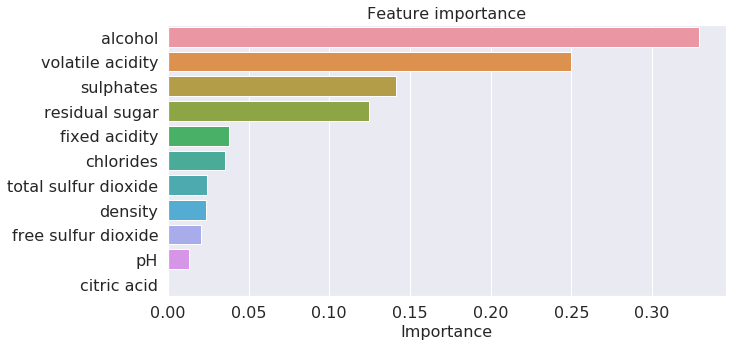

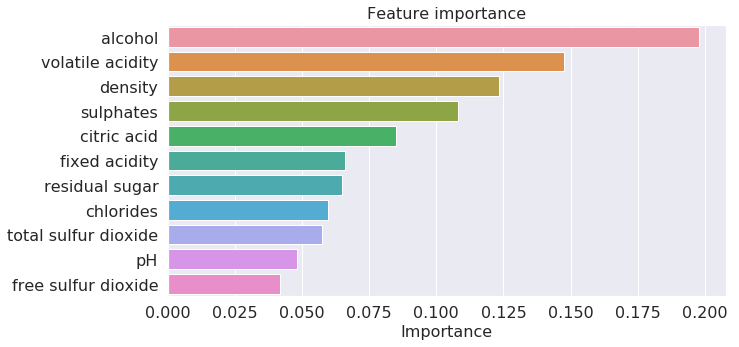

In [26]:
for feat_name in [tree_clf, forest_clf]:
    importanceTable = pd.DataFrame(feat_name.feature_importances_)
    featureNameList = pd.DataFrame(X.columns)
    importanceTable.columns = ['Importance']
    featureNameList.columns = ['Features']
    featureImportance = featureNameList.join(importanceTable)
    featureImportance = featureImportance.sort_values(['Importance'],ascending=False)
    plt.figure(figsize=(10,5))
    sns.barplot(x=featureImportance['Importance'],
                y=featureImportance['Features'])
    plt.xlabel('Importance',fontsize=16)
    plt.xticks(fontsize=16)
    plt.ylabel("")
    plt.yticks(fontsize=16)
    plt.title("Feature importance", fontsize=16)
    plt.show()

We observe that alcohol and volatile acidity are the most important features to classify quality.
Plotting the correlation between all the given variables has already shown that the most positively variable correlated with quality is alcohol. <br>
The others most important features are different in each models. 

# Conclusion

We first provide a naive baseline with a **regression** model.
The k-Nearest Neighbors Regressor, as a naive baseline, has achieved good performance with the RMSE metrics (not robust to outliers).
Besides, the k-NN Regressor has been improved of about 5% by a Grid-Search.

In a second step, we consider several **classification** models.
The overall results are not outstanding.
The models yield about the same results as the k-NN Regressor baseline.
But the RMSE and the accuracy score are different metrics, and no comparison between regression and classification models is perfectly relevant.
In regards to the Grid-Search strategy, a well-tuned model commonly  outperforms the default model.
However, the strategy didn't yield any impressive improvement for every models.
The Grid-Search strategy only manages to bring up the performance from 80-84% to 82-86%.
The hyper-parameters have to be carefully finetuned, so a deep knowledge of each models is required, together with a complete study, whereas this work is an overall overview.

Improvements perspectives:<br>
• fine tuning hyper-parameters.<br>
• test other models.<br>

These unsufficient results can be explained by models suffering from over-fitting or by dataset suffering from unbalanced values and outliers.
Besides, it seems to suggest that there might not be a clear correlation between quality and its physicochemical properties.

Despite all that, we can assert that alcohol is the most important feature for predicting the quality of wine.